# Predicting Hepatitis C- Modeling 

#### Independent Capstone: Springboard Data Science Career Track
Notebook by Naomi Lopez


The Goal of this project is to build a model that can effectively classify Hepatitis C status and severity from a data set of liver functional panel tests. Hepatitis C is a virus known to cause liver damage, cancer, and can lead to irreversible liver failure. It is commonsly spread through blood to blood contact with an infected person- most commonly by sharing needles used in intravenous drug use/ other methods used to inject drugs or in rare cases via blood transfusion. Other less commmon methods of transmission are sexual or with nicks or cuts caused by sharing nail clippers and/or tooth brushes with an infected person. There is a cure for Hepatitis C with a 95% effectiveness rate however many people go unscreened and pass the disease to others before receiving a diagnosis. 

A liver function panel test is a routine blood panel that is commonly completed at annual physical exams. Medical providers will order it to determine the internal state of the liver and is helpful in diagnosing a variety of internal conditions. Currently, the CDC recommends testing for Hepatitis C once in a persons life after age 18 or older. However, if a person were to test negative once and contract Hepatitis C later in life it may not register for a provider to screen again. 

The data set categories each patient into four categoreis, 0= Blood donor (hep c negative), 0s= Suspected Blood Donor (hep c negative), 1=Hepatitis (Hep C+ with liver inflammation), 2=Fibrosis (Hep C+ with advanced liver damanage), 3= Cirrhosis (Hep C+ with liver failure)

It will be interesting to investigate how well the model can accurately classify each participant's status based on their features (the multiple tests that are included in a liver function panel). On a broader scope, when abnormal liver function test values appear on a patient's results, it could potentially trigger Medical Providers to test for Hepatits C when it was previously not considered during an initial visit. 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
import scipy
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier




In [22]:
# Load the dataset
df= pd.read_csv('HepC.csv')

In [23]:
# Visualizing unique values in the object columns that will need to be transformed into dummy variables
print(df['Category'].unique()) # whether a person is Hep C - or +; if + they are categoriezed into grades of liver damage 1-3

print(df['Sex'].unique())

['0=Blood Donor' '0s=suspect Blood Donor' '1=Hepatitis' '2=Fibrosis'
 '3=Cirrhosis']
['m' 'f']


In [26]:
# Creating a dictionary to map Category values to numerical codes
category_mapping = {
    '0=Blood Donor': 0,
    '0s=suspect Blood Donor': 0,
    '1=Hepatitis': 1,
    '2=Fibrosis': 2,
    '3=Cirrhosis': 3
}

# Using .map to create a new column with numerical codes
df['Category_Numeric'] = df['Category'].map(category_mapping)

df['Category_Numeric'].value_counts()


Category_Numeric
0    540
3     28
1     23
2     21
Name: count, dtype: int64

Category 0 represents people who do NOT have Hepatitis C (Hep C negative). It makes up up about 75% of the data set. This is typical of the population where most people are Hep C negative and a small percent do have the virus. 

However, if the model is built on a heavily imbalanced data set, it will not be reliable. This issue needs to be addressed to avoid the model missing the Hep C + patients. To do this we need to create a balanced data set by undersampling the majority category. 

### Creating a Balanced Data Set by Undersampling the Majority Category

In [27]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df[df.Category_Numeric == 0]
df_minority_1 = df[df.Category_Numeric == 1]
df_minority_2 = df[df.Category_Numeric == 2]
df_minority_3 = df[df.Category_Numeric == 3]

# Find the maximum count among the minority classes
max_minority_count = max(len(df_minority_1), len(df_minority_2), len(df_minority_3))

# Undersample the majority class to have the same number of samples as the max of minority class sizes
df_majority_undersampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=max_minority_count, # to match max minority class size
                                    random_state=42)  # reproducible results

# Combine minority class with the undersampled majority class
df_balanced = pd.concat([df_majority_undersampled, df_minority_1, df_minority_2, df_minority_3])

# Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Use df_balanced for your model training
print(df_balanced['Category_Numeric'].value_counts())

Category_Numeric
3    28
0    28
1    23
2    21
Name: count, dtype: int64


In [28]:
df_balanced.head()
df_balanced.value_counts()

#The new df (df_balanced) has 100 participants evenly distributed between the different categories. 

Category       Age  Sex  ALB   ALT    AST    BIL   CHE   CREA   GGT    PROT  Category_Numeric
0=Blood Donor  32   m    46.3  17.5   17.8   8.5   7.01  70.0   16.9   74.5  0                   1
2=Fibrosis     54   m    41.0  41.5   187.9  21.0  8.59  91.0   104.9  79.1  2                   1
3=Cirrhosis    39   m    34.0  4.8    35.6   9.0   3.65  519.0  133.4  57.5  3                   1
               38   m    44.0  94.0   60.0   12.0  4.37  61.0   99.0   77.0  3                   1
2=Fibrosis     75   f    36.0  114.0  125.0  14.0  6.65  57.0   177.0  72.0  2                   1
                                                                                                ..
1=Hepatitis    25   m    42.0  63.3   187.7  14.0  6.00  66.9   40.2   70.5  1                   1
               23   m    47.0  38.9   164.2  17.0  7.09  79.3   90.4   70.1  1                   1
               19   m    41.0  87.0   67.0   12.0  7.55  62.0   65.0   75.0  1                   1
0=Blood Donor  

### Splitting and Training the Balanced Data Set

In [29]:
features = ['Age', 'ALB', 'ALT', 'AST', 'BIL', 'CHE', 'CREA',
       'GGT', 'PROT']

X = df_balanced[features]  # Features
y = df_balanced['Category_Numeric']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1A.) Gini Impurity Model 

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score


gini_model = DecisionTreeClassifier(criterion='gini', random_state=42)

# Fit the model to the training data
gini_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gini = gini_model.predict(X_test_scaled)

# Evaluate the model
print("Gini Impurity Model")
print("Accuracy:", accuracy_score(y_test, y_pred_gini))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_gini))
print('Precision score:', precision_score(y_test, y_pred_gini, average='weighted'))
print('Recall score:', recall_score(y_test, y_pred_gini, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred_gini, average='weighted'))

Gini Impurity Model
Accuracy: 0.65
Balanced accuracy: 0.7357142857142858
Precision score: 0.7766666666666666
Recall score: 0.65
F1 score: 0.6276143790849673


### 1B.) Grid Search on Gini Impurity Model 

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree model
gini_model = DecisionTreeClassifier(criterion='gini', random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=gini_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator
best_gini_model = grid_search.best_estimator_

# Predict on the test set
y_pred_gini_best = best_gini_model.predict(X_test_scaled)

# Evaluate the best model
print("Best Gini Impurity Model")
print("Best parameters found: ", grid_search.best_params_)



Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Gini Impurity Model
Best parameters found:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}


### 1C.) Gini Impurity with Parameter Tuning

Gini Impurity Model
Accuracy: 0.65
Balanced accuracy: 0.7214285714285714
Precision score: 0.7408333333333333
Recall score: 0.65
F1 score: 0.6357352941176471


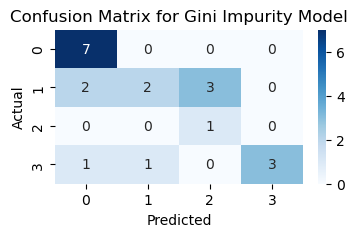

In [12]:
gini_model = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=1, min_samples_split=5, random_state=42)

# Fit the model to the training data
gini_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gini = gini_model.predict(X_test_scaled)

# Evaluate the model
print("Gini Impurity Model")
print("Accuracy:", accuracy_score(y_test, y_pred_gini))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_gini))
print('Precision score:', precision_score(y_test, y_pred_gini, average='weighted'))
print('Recall score:', recall_score(y_test, y_pred_gini, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred_gini, average='weighted'))



# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_gini)

# Plot the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gini Impurity Model')
plt.show()

### 1D.) Cross Validation 

In [13]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(gini_model, X, y, cv=5)  # 5-fold cross-validation

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())


Cross-validation scores: [0.45 0.55 0.65 0.6  0.5 ]
Mean cross-validation score: 0.55
Standard deviation of cross-validation scores: 0.07071067811865477


### 2A.) Entropy Model

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Create the Entropy model
entropy_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the model to the training data
entropy_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_entropy = entropy_model.predict(X_test_scaled)

# Evaluate the model
print("Entropy Model")
print("Accuracy:", accuracy_score(y_test, y_pred_entropy))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_entropy))
print('Precision score:', precision_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_entropy, average='weighted', zero_division=0))



Entropy Model
Accuracy: 0.6
Balanced accuracy: 0.6857142857142857
Precision score: 0.6933333333333332
Recall score: 0.6
F1 score: 0.6033333333333333


### 2B.) Grid Search on Entropy Model

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the Decision Tree model with entropy criterion
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Get the best model from grid search
best_dt_model = grid_search.best_estimator_

# Predict on the test set
y_pred_best_dt = best_dt_model.predict(X_test_scaled)

# Evaluate the best model
print("Best Entropy Model")
print("Best parameters found: ", best_dt_model)


Best Entropy Model
Best parameters found:  DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                       random_state=42)


### 2C.) Entropy Model with Parameter Tuning

Entropy Model
Accuracy: 0.7
Balanced accuracy: 0.5571428571428572
Precision score: 0.7322222222222223
Recall score: 0.7
F1 score: 0.7034722222222223


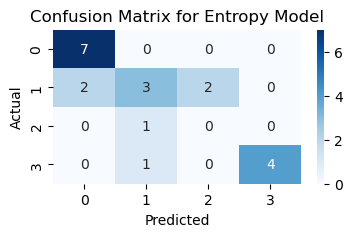

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Create the Entropy model
entropy_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, random_state=42)

# Fit the model to the training data
entropy_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_entropy = entropy_model.predict(X_test_scaled)


# Evaluate the model
print("Entropy Model")
print("Accuracy:", accuracy_score(y_test, y_pred_entropy))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_entropy))
print('Precision score:', precision_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_entropy, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_entropy, average='weighted', zero_division=0))



# Generate the confusion matrix
cm_entropy = confusion_matrix(y_test, y_pred_entropy)

# Plot the confusion matrix
plt.figure(figsize=(4,2))
sns.heatmap(cm_entropy, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Entropy Model')
plt.show() 

### 3A.) Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print('Precision score:', precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_rf, average='weighted', zero_division=0))


Random Forest Model
Accuracy: 0.8
Balanced accuracy: 0.8571428571428572
Precision score: 0.888888888888889
Recall score: 0.8
F1 score: 0.79125


### 3B.) Grid Search on Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_


print("Best RF Model")
print("Best parameters found: ", best_rf_model)


Best RF Model
Best parameters found:  RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)


### 3C.) Random Forest with Parameter Tuning

Random Forest Model
Accuracy: 0.75
Balanced accuracy: 0.8214285714285714
Precision score: 0.8847222222222222
Recall score: 0.75
F1 score: 0.7318055555555556
[[7 0 0 0]
 [2 2 3 0]
 [0 0 1 0]
 [0 0 0 5]]


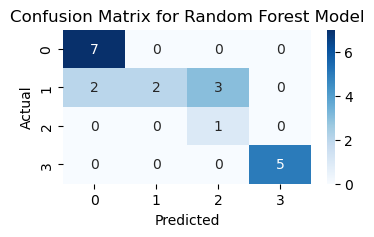

In [31]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(min_samples_split=10, n_estimators=50,random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print('Precision score:', precision_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_rf, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_rf, average='weighted', zero_division=0))

# Generate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Plot the confusion matrix
plt.figure(figsize=(4,2))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [32]:
# cross-validation with 5 folds
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# cross-validation scores and their mean and standard deviation
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

Cross-validation scores: [0.75 0.5  0.65 0.8  0.7 ]
Mean cross-validation score: 0.68
Standard deviation of cross-validation scores: 0.10295630140987003


### 4A.) Support Vector Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score

# Define the SVM model
svm_model = SVC(random_state=42, probability=True)  # Set probability=True to use predict_proba for ROC curve

# Fit the model to the training data
svm_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Support Vector Machine Model")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_svm))
print('Precision score:', precision_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_svm, average='weighted', zero_division=0))


### 4B.)Grid Search Support Vector Model 

In [ ]:
# Define the parameter grid for Grid Search

param_grid = {
    'C': [0.002,0.2,2,20,200],  # Expanded range
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Adjusted and expanded range
}



# Setup Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_svm_model = grid_search.best_estimator_


print(best_svm_model)

In [ ]:
# Define the SVM model
svm_model = SVC(C=0.2, kernel='linear', probability=True, random_state=42)  # Set probability=True to use predict_proba for ROC curve

# Fit the model to the training data
svm_model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
print("Support Vector Machine Model")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_svm))
print('Precision score:', precision_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('Recall score:', recall_score(y_test, y_pred_svm, average='weighted', zero_division=0))
print('F1 score:', f1_score(y_test, y_pred_svm, average='weighted', zero_division=0))


# Generate the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(4,2))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM Model')
plt.show()

In [ ]:
# Cross-validation
cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

### Comparison of Models
After evaluating multiple machine learning models, the Random Forest model proves to be the most effective classifier for this dataset. It outperforms the Support Vector Machine (SVM) model based on Accuracy, Balanced Accuracy, Precision, Recall, and F1 Score. When assessing performance using Cross Validation, both models show variability. However, the Random Forest's higher mean cross-validation score indicates better overall performance. Although the SVM has a lower standard deviation, suggesting more consistent results, the Random Forest model's superior mean score highlights its better generalization capability across different data subsets.

  Features  Importance scores
3      AST              0.120
7      GGT              0.070
1      ALB              0.065
0      Age              0.040
5      CHE              0.040
4      BIL              0.025
8     PROT              0.000
6     CREA             -0.010
2      ALT             -0.020


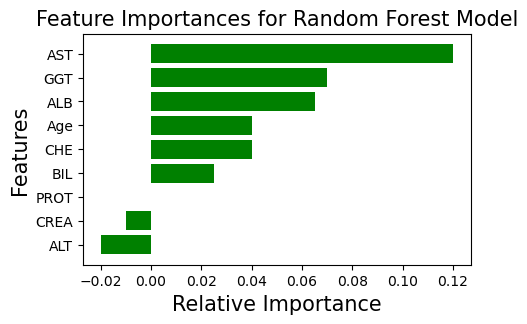

In [34]:
from sklearn.inspection import permutation_importance
# Permutation feature importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# DataFrame with feature names and their importance scores
features = X_test.columns  # column names from the test data
importances = perm_importance.importances_mean
tab = pd.DataFrame(list(zip(features, importances)), columns=['Features', 'Importance scores'])
tab = tab.sort_values(by='Importance scores', ascending=False)  # Sort by importance

# Print the DataFrame
print(tab)

# Visual comparison
plt.figure(figsize=(5, 3))

# Sort indices by feature importance
indices = np.argsort(importances)
sorted_features = [features[i] for i in indices]
sorted_importances = [importances[i] for i in indices]

plt.barh(sorted_features, sorted_importances, align='center', color='g')
plt.xlabel('Relative Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Feature Importances for Random Forest Model', fontsize=15)
plt.savefig("feature_importances_rfm.png")
plt.show()


### Feature Analysis

The two most important features identified were AST and GGT, which are enzymes produced by the liver. This finding aligns with expectations, as elevated levels of AST and GGT often indicate liver damage or bile duct issues. Given that Hepatitis C progressively damages the liver, increased levels of these enzymes are consistent with the disease's effects.

## ROC Curve

Class 0: AUC = 0.99
Class 1: AUC = 0.95
Class 2: AUC = 0.95
Class 3: AUC = 1.00


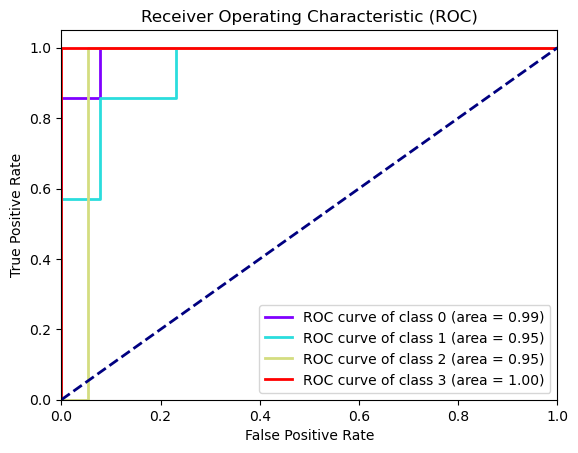

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Predict probabilities for the test set
y_prob_rf = rf_model.predict_proba(X_test)

# Number of classes
n_classes = len(np.unique(y_test))

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print AUC scores for each class
for i in range(n_classes):
    print(f'Class {i}: AUC = {roc_auc[i]:.2f}')
    
# Plot ROC Curves
plt.figure()
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Final Conclusion on Random Forest Model Performance


After evaluating multiple machine learning models, including Gini Impurity, Entropy, Random Forest (RF), and Support Vector Machine (SVM), the Random Forest model proved to be the most effective classifier for this dataset. It outperformed the SVM in terms of accuracy, balanced accuracy, precision, recall, and F1 score. The confusion matrix showed that Class 0 had the highest accuracy and Class 3 was perfectly classified. Class 1 had some confusion with Class 2. Overall, the model achieved an accuracy of 0.75, balanced accuracy of 0.82, precision of 0.88, recall of 0.75, and an F1 score of 0.73, indicating strong performance with room for improvement in recall and F1 score.

The ROC/AUC scores were excellent, with Class 0 at 0.99, Class 1 and Class 2 at 0.95, and Class 3 at 1.00, showing superior class discrimination. However,the cross-validation results, ranging from 0.50 to 0.80 with a mean score of 0.68, suggested some overfitting and sensitivity to data splits.

To enhance the model, exploring SMOTE for class balance, focusing on advanced feature engineering, implementing k-fold cross-validation, and considering Gradient Boosting could be beneficial. The RFM's strength in classifying Class 0 and Class 3 aligns with the significant differences in lab results between patients with and without Hepatitis C, indicating that a binary classification model might offer improved results.